In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import os
import cv2
import mediapipe as mp
from tkinter import*
from PIL import Image, ImageTk
import time
import pickle

In [2]:
# Load data from the pickle file
with open("train_data.pkl", 'rb') as f:
    saved_data = pickle.load(f)
with open("test_data.pkl", 'rb') as f:
    saved_data = pickle.load(f)

# Extract train and test data and labels from the loaded data
train_data, train_labels = saved_data
test_data, test_labels = saved_data

In [3]:
# Define the CNN model
def create_cnn(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # Flatten layer
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(27, activation='softmax'))

    return model

input_shape = train_data.shape[1:]  # Shape excluding the batch size dimension

asl_model = create_cnn(input_shape)

# Compile the model
asl_model.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

In [4]:
# Train the model
asl_model.fit(train_data, train_labels, epochs=45, batch_size=32)

Epoch 1/45
330/330 [==============================] - 4s 9ms/step - loss: 2.9419 - accuracy: 0.1396
Epoch 2/45
330/330 [==============================] - 4s 11ms/step - loss: 1.7211 - accuracy: 0.4518
Epoch 3/45
330/330 [==============================] - 3s 8ms/step - loss: 1.1679 - accuracy: 0.6407
Epoch 4/45
330/330 [==============================] - 2s 6ms/step - loss: 0.9292 - accuracy: 0.7243
Epoch 5/45
330/330 [==============================] - 2s 5ms/step - loss: 0.8138 - accuracy: 0.7708
Epoch 6/45
330/330 [==============================] - 2s 6ms/step - loss: 0.7446 - accuracy: 0.7952
Epoch 7/45
330/330 [==============================] - 8s 23ms/step - loss: 0.6883 - accuracy: 0.8066
Epoch 8/45
330/330 [==============================] - 7s 22ms/step - loss: 0.6506 - accuracy: 0.8168
Epoch 9/45
330/330 [==============================] - 5s 15ms/step - loss: 0.6071 - accuracy: 0.8298
Epoch 10/45
330/330 [==============================] - 3s 8ms/step - loss: 0.5913 - accuracy: 0.

In [5]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = asl_model.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

330/330 [==============================] - 1s 2ms/step - loss: 0.2046 - accuracy: 0.9379
Test Loss: 0.20461685955524445
Test Accuracy: 0.9378793835639954


330/330 [==============================] - 1s 2ms/step


C:\Users\katie\AppData\Local\Temp\ipykernel_47844\1117495628.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')


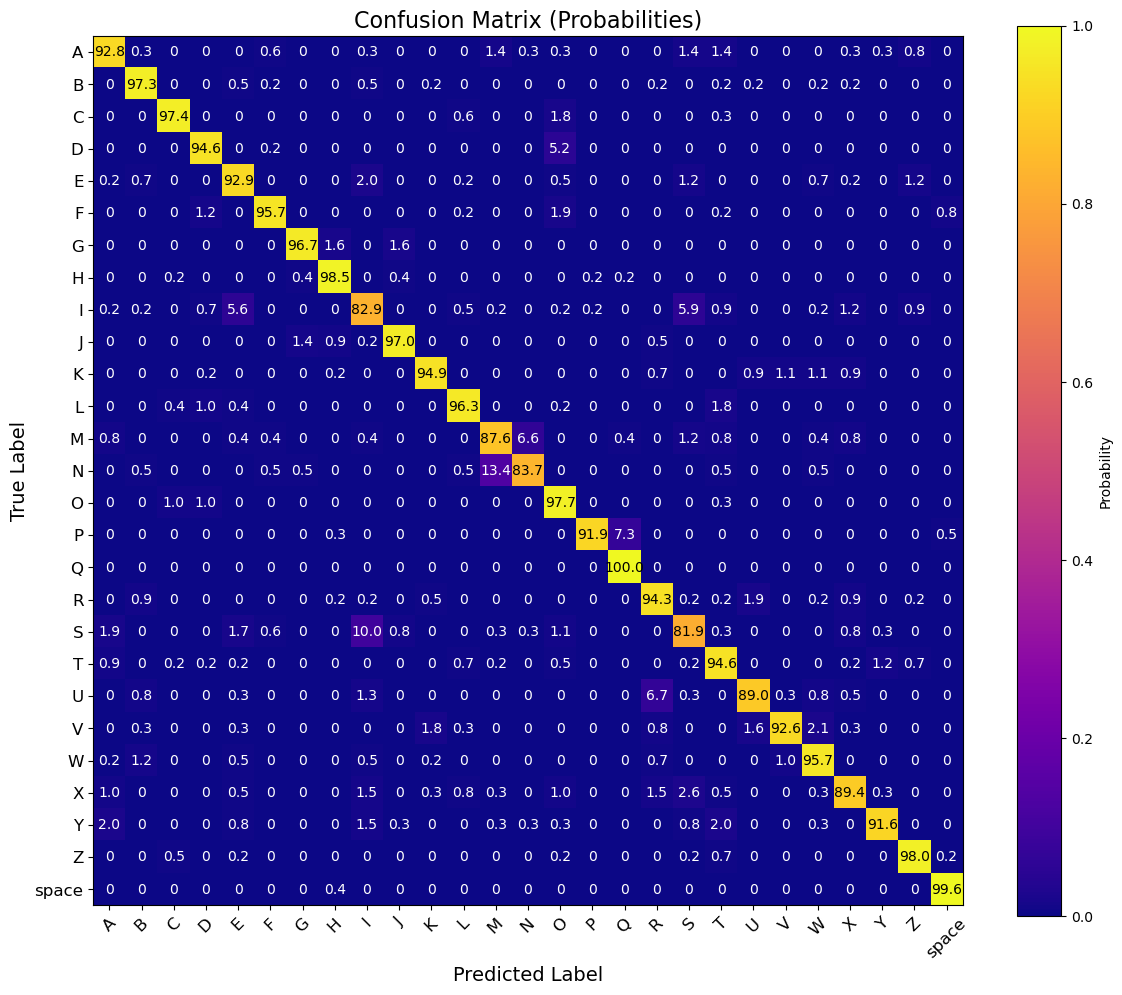

In [6]:
# Define labels for letters and space
labels_letters = [chr(ord('A') + i) for i in range(26)]
labels_letters.append('space')

# Make predictions
preds = asl_model.predict(test_data)

# Make confusion matrix
conf_matrix = confusion_matrix(test_labels, np.argmax(preds, axis=1), normalize='true')

# Plot the confusion matrix with probabilities
plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix (Probabilities)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(np.arange(27), labels_letters, fontsize=12, rotation=45)
plt.yticks(np.arange(27), labels_letters, fontsize=12)

# Add a color gradient to show probabilities
cmap = plt.cm.get_cmap('plasma')
plt.imshow(conf_matrix, cmap=cmap)

# Add text with probabilities
for i in range(27):
    for j in range(27):
        text_color = 'white' if conf_matrix[i, j] < 0.5 else 'black'  # Choose text color based on contrast
        prob_text = f'{conf_matrix[i, j]*100:.1f}' if conf_matrix[i, j] > 0 else '0'
        plt.text(j, i, prob_text, ha='center', va='center', color=text_color, fontsize=10)

plt.colorbar(label='Probability')  # Add colorbar
plt.tight_layout()
plt.show()

In [8]:
# Using mediapipe to recognize hands. Model takes landmarks as input

def detect_right_hand_up(landmarks):
    # Check if the thumb tip landmark is above the other fingers
    if landmarks[8, 1] < min(landmarks[5:8, 1]):
        return True
    return False

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

def extract_landmarks(image):
    # Convert image to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process image to detect hand landmarks
    results = hands.process(rgb_image)

    print("results: ")
    print(results.multi_hand_landmarks)
    
    # Initialize an empty dictionary to store landmarks for each hand
    landmarks_dict = {"Left": None, "Right": None}
    
    # If hand landmarks are detected
    if results.multi_hand_landmarks:

        # Iterate through each detected hand
        for hand_landmarks in results.multi_hand_landmarks:
            # Get the hand type (left or right)
            hand_type = "Right" if hand_landmarks.landmark[0].x < hand_landmarks.landmark[20].x else "Left"
            
            # Extract X and Y coordinates of each landmark for the current hand
            landmark_coords = np.array([(landmark.x, landmark.y) for landmark in hand_landmarks.landmark])
            
            # Store the landmarks in the dictionary based on hand type
            landmarks_dict[hand_type] = landmark_coords
    
    return landmarks_dict

def get_frame_info(frame):
    # Accessing hand landmarks
    landmarks = extract_landmarks(frame)
    # print(landmarks)
    left_landmarks = landmarks["Left"]
    right_landmarks = landmarks["Right"]

    print(left_landmarks is not None)
    print(right_landmarks is not None)

    predicted_letter, max_probability, thumbs_up = None, None, None  # Default values
    
    if left_landmarks is not None:  # Check if left_landmarks is not None
        thumbs_up = detect_right_hand_up(right_landmarks) if right_landmarks is not None else None
        
        left_landmarks = left_landmarks.reshape((1, 21, 2))
        
        # Make predictions
        predictions = asl_model.predict(left_landmarks)

        max_probability = np.max(predictions)

        # Get the index of the class with the highest probability
        predicted_class = np.argmax(predictions)

        class_to_letter = {
            0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
            10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S',
            19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'space'
        }

        # Map the predicted class to the corresponding letter
        predicted_letter = class_to_letter[predicted_class]

        # Print the predicted letter and thumbs-up status
        print('Predicted letter:', predicted_letter)

    return predicted_letter, max_probability, thumbs_up


In [ ]:
# OpenCV code to capture video and annotate it
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Get frame information
    predicted_letter, max_probability, thumbs_up = get_frame_info(frame)

    # Annotate the frame
    if predicted_letter:
        cv2.putText(frame, f'Prediction: {predicted_letter}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Sign Language Translator', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()